In [1]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\t

C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SCMI\Anaconda3\envs\prnv\lib\site-packages\tensor

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from c2ae import build_classifier_v2, build_c2ae
from utils import LATENT_DIM,EFNB4_INPUT_SHAPE,EFNB2_INPUT_SHAPE,\
                        EFNB3_INPUT_SHAPE,DENSENET121_INPUT_SHAPE,NUM_CLASSES
from model import build_encoder_v2
from keras.models import load_model, Model
from keras.layers import Input,Add,Multiply
from openset_test_generator import openset_generator
import numpy as np

from sklearn.metrics import accuracy_score,precision_score,recall_score,\
                            f1_score,balanced_accuracy_score,roc_auc_score,\
                            confusion_matrix
import joblib
import matplotlib.pyplot as plt

C:\Users\SCMI\Desktop\projects\ISIC\isic_c2ae\openset_test_generator.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openset_data['X'][i] = ISIC_BASE_DIR + openset_data['X'][i]
C:\Users\SCMI\Desktop\projects\ISIC\isic_c2ae\openset_test_generator.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openset_data['Y_LE_ASC'][i] = mapp[openset_data['Y'][i]]
C:\Users\SCMI\Desktop\projects\ISIC\isic_c2ae\openset_test_generator.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [3]:
def get_encoder(model_name,ver='v1'):
    if model_name == 'efnb4':
        efnb4 = build_encoder_v2(LATENT_DIM,'efnb4')
        efnb4_classifier = build_classifier_v2(efnb4,EFNB4_INPUT_SHAPE)
        efnb4_classifier.load_weights('models/efnb4-v2-save-05-0.516.hdf5')
        encoder = efnb4_classifier.layers[1]
        encoder.trainable = False
        return encoder
    if model_name == 'efnb3':
        efnb3 = build_encoder_v2(LATENT_DIM,'efnb3')
        efnb3_classifier = build_classifier_v2(efnb3,EFNB2_INPUT_SHAPE)
        efnb3_classifier.load_weights('models/efnb3-v2-save-07-0.526.hdf5')
        encoder = efnb3_classifier.layers[1]
        encoder.trainable = False
        return encoder
    if model_name == 'efnb2':
        efnb2 = build_encoder_v2(LATENT_DIM,'efnb2')
        efnb2_classifier = build_classifier_v2(efnb2,EFNB2_INPUT_SHAPE)
        efnb2_classifier.load_weights('models/efnb2-v2-save-07-0.553.hdf5')
        encoder = efnb2_classifier.layers[1]
        encoder.trainable = False
        return encoder
    if model_name == 'densenet121':
        if ver=='v1':
            dnet121_classifier = load_model('models/densenet121-v2-save-04-0.59.hdf5')
            encoder = dnet121_classifier.layers[1]
            encoder.trainable = False
        else:
            dnet121_classifier = load_model('models/densenet121-v2-save-04-0.59.hdf5')
            enc = dnet121_classifier.layers[1]
            dnet = enc.layers[1]
            dnet.layers.pop()
            encoder = Model(dnet.inputs,dnet.layers[-1].output)
            encoder.trainable = False
        return encoder

In [4]:
def gen_label_condition_vecs(image_labels):
    batch_size = len(image_labels)
    l = np.ones((batch_size,8,)) * -1
    indxs = np.arange(0,batch_size)
    l[indxs,image_labels] = 1
    return l

def l2_numpy_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

In [5]:
def get_classifier(model_name):
    if model_name == 'densenet121':
        classifier = load_model('models/densenet121-v2-save-04-0.59.hdf5')
    elif model_name == 'efnb2':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb2'),
                                               EFNB2_INPUT_SHAPE)
        classifier.load_weights('models/efnb2-v2-save-07-0.553.hdf5')
    elif model_name == 'efnb3':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb3'),
                                               EFNB3_INPUT_SHAPE)
        classifier.load_weights('models/efnb3-v2-save-07-0.526.hdf5')
    elif model_name == 'efnb4':
        classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb4'),
                                               EFNB4_INPUT_SHAPE)
        classifier.load_weights('models/efnb4-v2-save-05-0.516.hdf5')    
    return classifier

In [25]:
classifier = get_classifier('efnb3')

50094080/50086816 [==============================] - 29s 1us/step


In [7]:
#densenet_classifier = load_model('models/densenet121-v2-save-04-0.59.hdf5')

In [8]:
'''
efnb2_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb2'),
                                       EFNB2_INPUT_SHAPE)
efnb3_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb3'),
                                       EFNB3_INPUT_SHAPE)
efnb4_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb4'),
                                       EFNB4_INPUT_SHAPE)
efnb2_classifier.load_weights('models/efnb2-v2-save-07-0.553.hdf5')
efnb3_classifier.load_weights('models/efnb3-v2-save-07-0.526.hdf5')
efnb4_classifier.load_weights('models/efnb4-v2-save-05-0.516.hdf5')
'''

"\nefnb2_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb2'),\n                                       EFNB2_INPUT_SHAPE)\nefnb3_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb3'),\n                                       EFNB3_INPUT_SHAPE)\nefnb4_classifier = build_classifier_v2(build_encoder_v2(LATENT_DIM,'efnb4'),\n                                       EFNB4_INPUT_SHAPE)\nefnb2_classifier.load_weights('models/efnb2-v2-save-07-0.553.hdf5')\nefnb3_classifier.load_weights('models/efnb3-v2-save-07-0.526.hdf5')\nefnb4_classifier.load_weights('models/efnb4-v2-save-05-0.516.hdf5')\n"

In [9]:
c2ae_perceptual = build_c2ae('densenet121','v2')[-1]
c2ae_perceptual.load_weights('models/c2ae/v2c2ae-densenet-white-save-0.8-04-7.576-8.400.hdf5')
H_gamma = c2ae_perceptual.layers[3]
H_gamma.trainable=False
H_beta = c2ae_perceptual.layers[5]
H_beta.trainable=False
DenseNetDecoder = c2ae_perceptual.layers[9]
DenseNetDecoder.trainable=False
DenseNetEncoder = get_encoder('densenet121','v2')
input_image = Input(shape=DENSENET121_INPUT_SHAPE)
z = DenseNetEncoder(input_image)
l = Input(shape=(NUM_CLASSES,))
gamma = H_gamma(l)
beta = H_beta(l)
z_l = Multiply()([z,gamma])
z_l = Add()([z_l,beta])
reconstruction = DenseNetDecoder(z_l)
c2ae = Model(inputs=[input_image,l],outputs=reconstruction)

c2ae.summary()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
model_11 (Model)                (None, 7, 7, 1024)   7037504     input_11[0][0]                   
__________________________________________________________________________________________________
H_gamma (Model)                 (None, 7, 7, 1024)   451584      input_12[0][0]                   
___________

(array([2794., 6605., 3865., 2198., 1848., 1319., 1203.,  335.,   70.,
          27.]),
 array([0.06380215, 0.13233483, 0.20086751, 0.26940018, 0.33793286,
        0.40646554, 0.47499822, 0.54353089, 0.61206357, 0.68059625,
        0.74912892]),
 <a list of 10 Patch objects>)

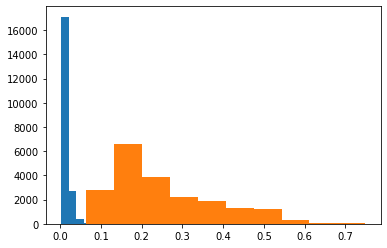

In [10]:
match_recon = joblib.load('recon_errors/v2densenet-0.8-04-match_recon.pkl')
nonmatch_recon = joblib.load('recon_errors/v2densenet-0.8-04-nonmatch_recon.pkl')

plt.hist(match_recon)
plt.hist(nonmatch_recon)

In [37]:
RECON_THRESHOLD = 0.05

In [38]:
batch_size=16
nb = int(np.ceil(11275/batch_size))
os_generator = openset_generator(batch_size,EFNB3_INPUT_SHAPE[:-1],starti=0)

In [39]:
y_true_labels = []
y_pred_labels = []

In [40]:
for b in range(nb):
    batch = next(os_generator)
    preds=classifier.predict_on_batch(batch[0])
    y_pred = []
    y_pred_prob = []
    for i in range(len(preds)):
        y_pred.append(np.argmax(preds[i,:]))
        y_pred_prob.append(preds[i,5])
    y_pred_cond_vecs = gen_label_condition_vecs(y_pred)
    recons = c2ae.predict_on_batch([batch[1],y_pred_cond_vecs])
    decoder_images = batch[2][0]
    recon_errors = []
    for i in range(len(y_pred)):
        re = l2_numpy_loss(decoder_images[i,:,:,:],recons[i,:,:,:])
        recon_errors.append(re)
        if re>RECON_THRESHOLD:
            y_pred[i] = 8
    y_true_labels.extend(batch[2][2])
    y_pred_labels.extend(y_pred)
    print(b)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
recon_errors

[0.062213404366094446,
 0.046900420466636186,
 0.06814984587329,
 0.035257130319076964,
 0.07415654960497728,
 0.05429474209963784,
 0.04823082502790861,
 0.05786864866921287,
 0.08782926411751592,
 0.04921842682790021,
 0.044874548991676415]

In [42]:
print('Normalized Accuracy: ',accuracy_score(y_true_labels,y_pred_labels))
print('Precision Score    : ',precision_score(y_true_labels,y_pred_labels, average='macro'))
print('Recall Score       : ',recall_score(y_true_labels,y_pred_labels, average='macro'))
print('F1 Score           : ',f1_score(y_true_labels,y_pred_labels,average='macro'))
print('Balanced Accuracy  : ',balanced_accuracy_score(y_true_labels,y_pred_labels))

Normalized Accuracy:  0.5198226164079822
Precision Score    :  0.48440268999326186
Recall Score       :  0.6493518245551376
F1 Score           :  0.50028420226757
Balanced Accuracy  :  0.6493518245551376


In [43]:
confusion_matrix(y_true_labels,y_pred_labels)

array([[  91,   26,   41,    2,   13,    4,    9,    0,    0],
       [  29,  449,   20,   14,   57,   35,   16,    7,    6],
       [  24,    9,  419,    7,   27,   41,    3,    5,    7],
       [   1,    1,    2,   35,    1,    2,    0,    0,    0],
       [   7,    6,   70,    5,  569,  200,    0,    1,   31],
       [   3,   16,  103,   33,   94, 1817,    0,    8,  512],
       [  10,   19,   35,    5,    7,    3,   53,    0,    0],
       [   0,    0,    0,    3,    0,    2,    0,   52,    0],
       [  25,   25,  215,   36, 1036, 2325,    8,  162, 2376]],
      dtype=int64)